## **Install PySpark**

In [1]:
!pip install pyspark
!pip install findspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1 

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 50.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=0c7979ba73e68cfb9dc9566244a01fe9e2c150c15c04ec6f0552e2e0b217c7f5
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


## **Import all the useful packages**

In [2]:
from tqdm import tqdm

import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark.sql.functions as f
#from pyspark.sql.functions import split, regexp_replace, year, month, dayofmonth, to_timestamp

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Bucketizer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

from pyspark.mllib.feature import HashingTF, IDF

# Basic libreries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from yellowbrick.target import FeatureCorrelation

## **Configuration of PySpark and check**

In [3]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

## **Data Acquisition**

### Mount Google Drive point

In [5]:
GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Your own home directory
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR +  "/Sapienza/Primo Anno/Big Data Computing/Project"

# Point Colaboratory to our Google Drive
from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

DATASET_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

Mounted at /content/gdrive


### Retrieving Dataset and stored it

In [6]:
import requests

"""
This function downloads a file from a specific URL directly to Google Drive.
"""
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200: # Test if everything went ok
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)

In [7]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/Sapienza/Primo Anno/Big Data Computing/Project/dataframe.csv


### Read DataSet file into PySpark dataframe

In [8]:
spotify_tracks = spark.read.load(GDRIVE_DATASET_FILE, 
                           format="csv", 
                           sep=";", 
                           inferSchema="true", 
                           header="true")

In [9]:
spotify_tracks.cache()

DataFrame[id: string, track_name: string, track_explicit: boolean, track_popularity: int, album_name: string, album_release_date: string, album_release_date_precision: string, artist_name: string, audio_avg_pitches: string, audio_avg_timbre: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_uri: string, track_genre: string]

### Check the shape of the loaded dataset, i.e., number of rows and columns

In [10]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(spotify_tracks.count(), len(spotify_tracks.columns)))

The shape of the dataset is 79339 rows by 25 columns


### Print out the schema of the loaded dataset

In [11]:
spotify_tracks.printSchema()

root
 |-- id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_avg_pitches: string (nullable = true)
 |-- audio_avg_timbre: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio

# **Dataset Shape**

## **Print the 5 rows of the load dataset**

In [12]:
spotify_tracks.show(5)

+--------------------+-----------------+--------------+----------------+--------------------+------------------+----------------------------+---------------+--------------------+--------------------+------------------+------------------+-----------------+------------+----------------------+-----------+--------------+--------------+------------+-----------------+-----------+--------------------+-------------+--------------------+-----------+
|                  id|       track_name|track_explicit|track_popularity|          album_name|album_release_date|album_release_date_precision|    artist_name|   audio_avg_pitches|    audio_avg_timbre|audio_acousticness|audio_danceability|audio_duration_ms|audio_energy|audio_instrumentalness|audio_key_1|audio_liveness|audio_loudness|audio_mode_1|audio_speechiness|audio_tempo|audio_time_signature|audio_valence|           track_uri|track_genre|
+--------------------+-----------------+--------------+----------------+--------------------+-----------------

In [13]:
# Drop duplicates and split the columns using PySpark
spotify_tracks = spotify_tracks.dropDuplicates()

# **Clear and Organize the Dataset**

## Split "audio_avg_pitches" and "audio_avg_timbre" columns

In [14]:
# Split String audio_avg_pitches to n columns
spotify_tracks = spotify_tracks.select(spotify_tracks.columns + [f.translate(f.col("audio_avg_pitches"), "[]", "").alias("audio_avg_pitches_list")])
spotify_tracks = spotify_tracks.withColumn("pitch_1", split(col("audio_avg_pitches_list"), ", ").getItem(0))\
                                .withColumn("pitch_2", split(col("audio_avg_pitches_list"), ", ").getItem(1))\
                                .withColumn("pitch_3", split(col("audio_avg_pitches_list"), ", ").getItem(2))\
                                .withColumn("pitch_4", split(col("audio_avg_pitches_list"), ", ").getItem(3))\
                                .withColumn("pitch_5", split(col("audio_avg_pitches_list"), ", ").getItem(4))\
                                .withColumn("pitch_6", split(col("audio_avg_pitches_list"), ", ").getItem(5))\
                                .withColumn("pitch_7", split(col("audio_avg_pitches_list"), ", ").getItem(6))\
                                .withColumn("pitch_8", split(col("audio_avg_pitches_list"), ", ").getItem(7))\
                                .withColumn("pitch_9", split(col("audio_avg_pitches_list"), ", ").getItem(8))\
                                .withColumn("pitch_10", split(col("audio_avg_pitches_list"), ", ").getItem(9))\
                                .withColumn("pitch_11", split(col("audio_avg_pitches_list"), ", ").getItem(10))\
                                .withColumn("pitch_12", split(col("audio_avg_pitches_list"), ", ").getItem(11))

In [15]:
# Split String audio_avg_timbre to n columns
spotify_tracks = spotify_tracks.select(spotify_tracks.columns + [f.translate(f.col("audio_avg_timbre"), "[]", "").alias("audio_avg_timbre_list")])
spotify_tracks = spotify_tracks.withColumn("timbre_1", split(col("audio_avg_timbre_list"), ", ").getItem(0))\
                                .withColumn("timbre_2", split(col("audio_avg_timbre_list"), ", ").getItem(1))\
                                .withColumn("timbre_3", split(col("audio_avg_timbre_list"), ", ").getItem(2))\
                                .withColumn("timbre_4", split(col("audio_avg_timbre_list"), ", ").getItem(3))\
                                .withColumn("timbre_5", split(col("audio_avg_timbre_list"), ", ").getItem(4))\
                                .withColumn("timbre_6", split(col("audio_avg_timbre_list"), ", ").getItem(5))\
                                .withColumn("timbre_7", split(col("audio_avg_timbre_list"), ", ").getItem(6))\
                                .withColumn("timbre_8", split(col("audio_avg_timbre_list"), ", ").getItem(7))\
                                .withColumn("timbre_9", split(col("audio_avg_timbre_list"), ", ").getItem(8))\
                                .withColumn("timbre_10", split(col("audio_avg_timbre_list"), ", ").getItem(9))\
                                .withColumn("timbre_11", split(col("audio_avg_timbre_list"), ", ").getItem(10))\
                                .withColumn("timbre_12", split(col("audio_avg_timbre_list"), ", ").getItem(11))

In [16]:
spotify_tracks.printSchema()

root
 |-- id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_avg_pitches: string (nullable = true)
 |-- audio_avg_timbre: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio

## Convert to DateTime and Split "album_release_date" to "year", "month" and "day" columns.

In [17]:
def to_date_(col, formats=("yyyy-MM-dd", "y")):
    # Spark 2.2 or later syntax, for < 2.2 use unix_timestamp and cast
    return coalesce(*[to_date(col, f) for f in formats])

spotify_tracks = spotify_tracks.withColumn("album_release_date_td", to_date_("album_release_date"))

In [18]:
# Split date to columns
spotify_tracks = spotify_tracks.withColumn('day', dayofmonth(col('album_release_date_td')))
spotify_tracks = spotify_tracks.withColumn('month', month(col('album_release_date_td')))
spotify_tracks = spotify_tracks.withColumn('year', year(col('album_release_date_td')))

## Delete unless columns

In [19]:
# Delete columns
cols = ("album_release_date", "album_release_date_td", "audio_avg_pitches","audio_avg_timbre", "audio_avg_pitches_list", "audio_avg_timbre_list", "track_uri", "id")
spotify_tracks = spotify_tracks.drop(*cols)

## Convert "pitch_i", "timbre_i", "year", "month" and "day" columns to correct types.

In [20]:
# Cast converted columns
spotify_tracks = spotify_tracks.withColumn("pitch_1", spotify_tracks.pitch_1.cast('double'))\
                                .withColumn("pitch_2", spotify_tracks.pitch_2.cast('double'))\
                                .withColumn("pitch_3", spotify_tracks.pitch_3.cast('double'))\
                                .withColumn("pitch_4", spotify_tracks.pitch_4.cast('double'))\
                                .withColumn("pitch_5", spotify_tracks.pitch_5.cast('double'))\
                                .withColumn("pitch_6", spotify_tracks.pitch_6.cast('double'))\
                                .withColumn("pitch_7", spotify_tracks.pitch_7.cast('double'))\
                                .withColumn("pitch_8", spotify_tracks.pitch_8.cast('double'))\
                                .withColumn("pitch_9", spotify_tracks.pitch_9.cast('double'))\
                                .withColumn("pitch_10", spotify_tracks.pitch_10.cast('double'))\
                                .withColumn("pitch_11", spotify_tracks.pitch_11.cast('double'))\
                                .withColumn("pitch_12", spotify_tracks.pitch_12.cast('double'))

spotify_tracks = spotify_tracks.withColumn("timbre_1", spotify_tracks.timbre_1.cast('double'))\
                                .withColumn("timbre_2", spotify_tracks.timbre_2.cast('double'))\
                                .withColumn("timbre_3", spotify_tracks.timbre_3.cast('double'))\
                                .withColumn("timbre_4", spotify_tracks.timbre_4.cast('double'))\
                                .withColumn("timbre_5", spotify_tracks.timbre_5.cast('double'))\
                                .withColumn("timbre_6", spotify_tracks.timbre_6.cast('double'))\
                                .withColumn("timbre_7", spotify_tracks.timbre_7.cast('double'))\
                                .withColumn("timbre_8", spotify_tracks.timbre_8.cast('double'))\
                                .withColumn("timbre_9", spotify_tracks.timbre_9.cast('double'))\
                                .withColumn("timbre_10", spotify_tracks.timbre_10.cast('double'))\
                                .withColumn("timbre_11", spotify_tracks.timbre_11.cast('double'))\
                                .withColumn("timbre_12", spotify_tracks.timbre_12.cast('double'))

spotify_tracks = spotify_tracks.withColumn("year", spotify_tracks.year.cast('int'))\
                                .withColumn("day", spotify_tracks.day.cast('int'))\
                                .withColumn("month", spotify_tracks.month.cast('int'))

spotify_tracks.printSchema()


root
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio_time_signature: integer (nullable = true)
 |-- audio_valence: double (nullable = true)
 |-- track_genre: string (nullable = true)
 |-- pitch_1: double (nullable = true)
 |-- pitch_

## Look and delete possible Null Value

In [21]:
# null values in each column
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
spotify_tracks.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in spotify_tracks.columns]).show()

+----------+--------------+----------------+----------+----------------------------+-----------+------------------+------------------+-----------------+------------+----------------------+-----------+--------------+--------------+------------+-----------------+-----------+--------------------+-------------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---+-----+----+
|track_name|track_explicit|track_popularity|album_name|album_release_date_precision|artist_name|audio_acousticness|audio_danceability|audio_duration_ms|audio_energy|audio_instrumentalness|audio_key_1|audio_liveness|audio_loudness|audio_mode_1|audio_speechiness|audio_tempo|audio_time_signature|audio_valence|track_genre|pitch_1|pitch_2|pitch_3|pitch_4|pitch_5|pitch_6|pitch_7|pitch_8|pitch_9|pitch_10|pitch_11|pitch_12|timbre_1|timbre_2|timbre_3|timbre_4

In [22]:
spotify_tracks = spotify_tracks.dropna()

# **Data Exploration**

In this section of the notebook, we're going to show some graphics, i.e. the correlation map of the feaure, the most famous tracks, the most famous artists and so on.

In [23]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
spotify_tracks_pd = spotify_tracks.toPandas() 

## Visualization of Variability for some columns in the dataframe

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

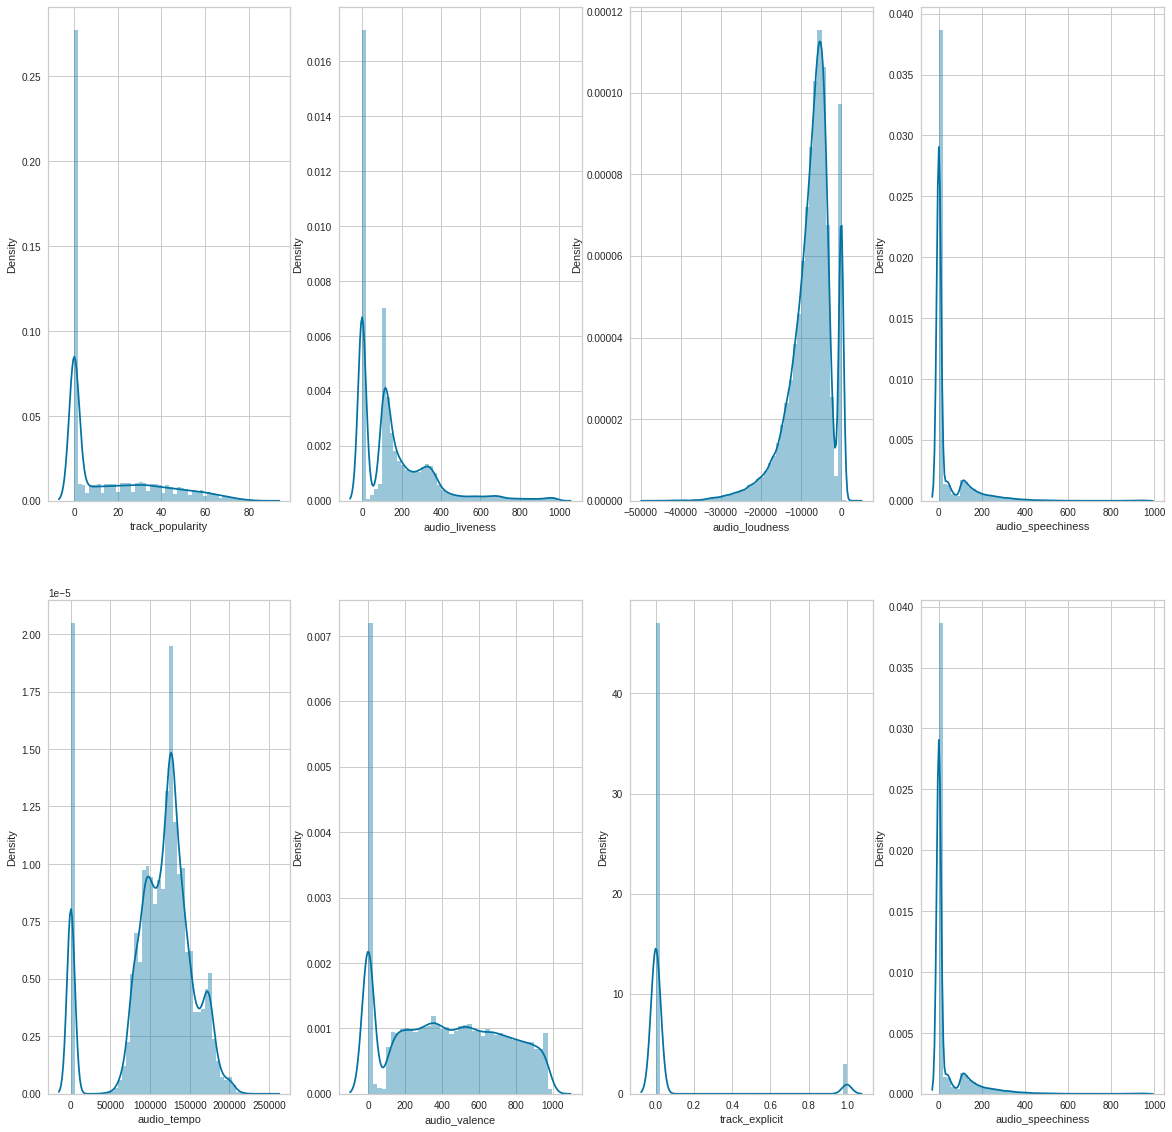

In [24]:
#Visualisation of Variability for some columns in the dataframe
fig,ax = plt.subplots(2,4,figsize=(20,20))

sns.distplot(spotify_tracks_pd['track_popularity'],ax=ax[0,0])
sns.distplot(spotify_tracks_pd['audio_liveness'],ax=ax[0,1])
sns.distplot(spotify_tracks_pd['audio_loudness'],ax=ax[0,2])
sns.distplot(spotify_tracks_pd['audio_speechiness'],ax=ax[0,3])
sns.distplot(spotify_tracks_pd['audio_tempo'],ax=ax[1,0])
sns.distplot(spotify_tracks_pd['audio_valence'],ax=ax[1,1])
sns.distplot(spotify_tracks_pd['track_explicit'],ax=ax[1,2])
sns.distplot(spotify_tracks_pd['audio_speechiness'],ax=ax[1,3])

## Correlation Map

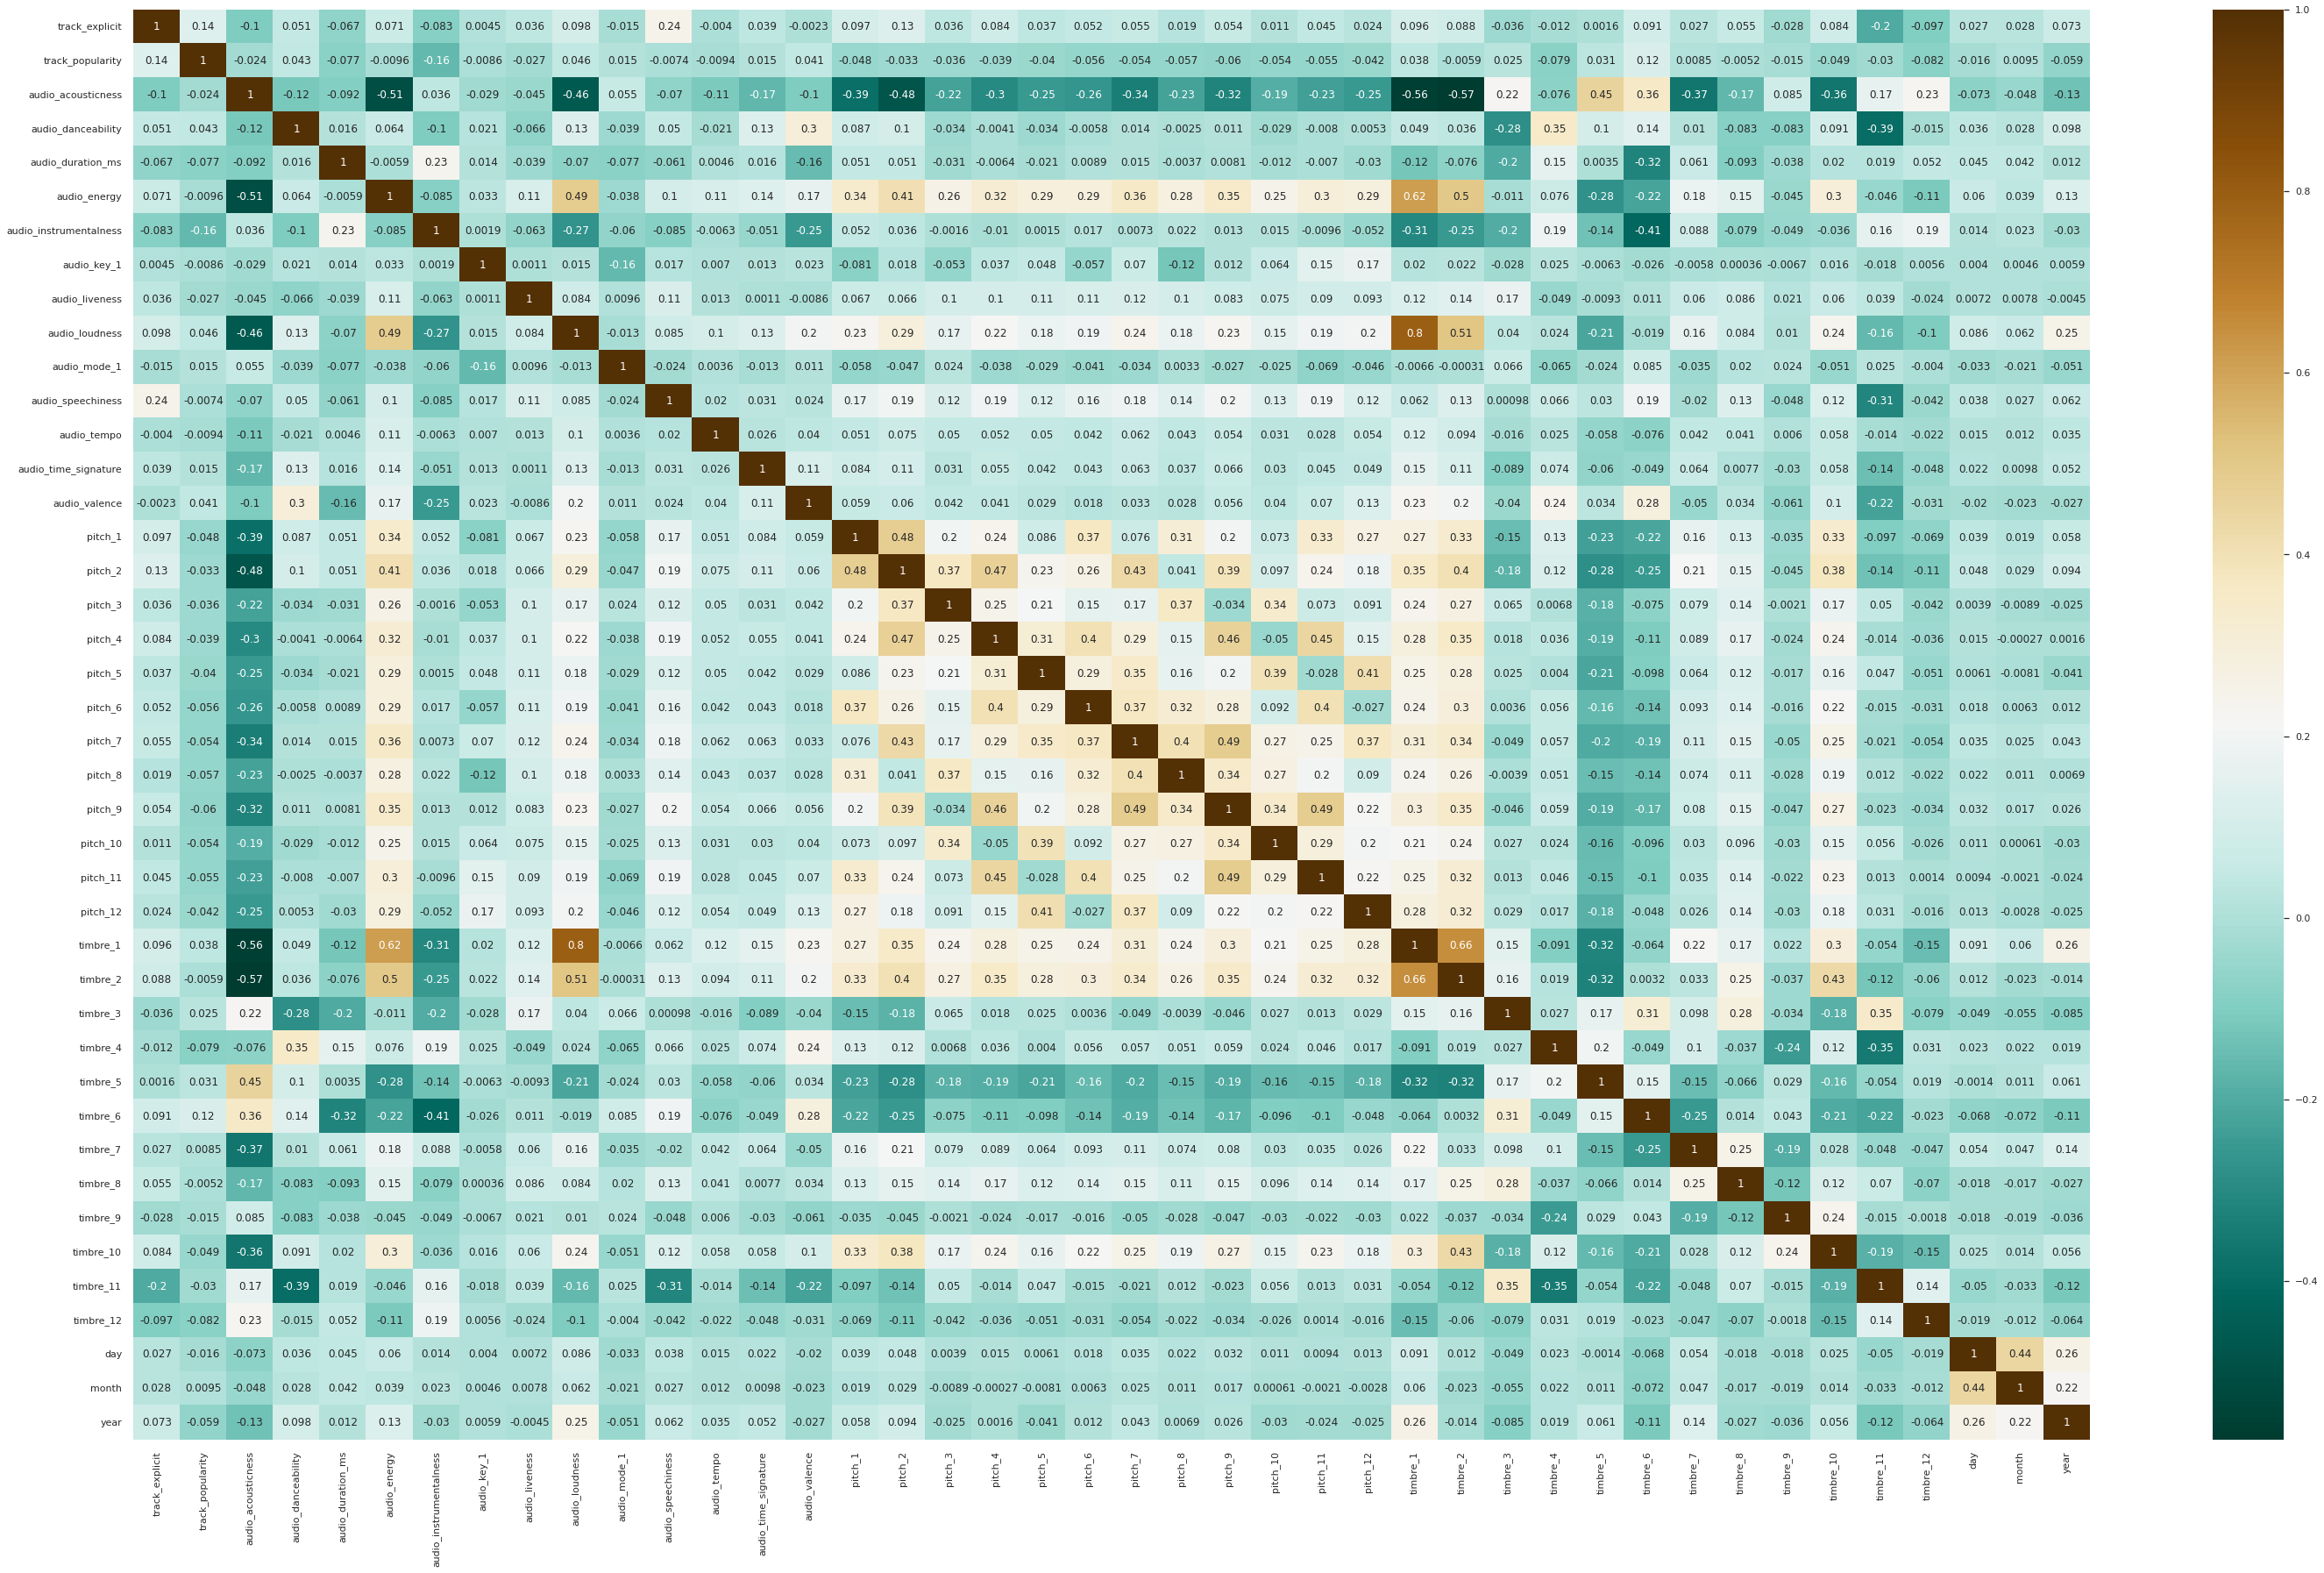

In [25]:
plt.figure(figsize=(50,30))
sns.set(style="whitegrid")
corr = spotify_tracks_pd.corr()
sns.heatmap(corr,annot=True,cmap='BrBG_r',annot_kws={"fontsize":12})

As we can see from the heatmap there are no highly correlated features so for now it is not necessary to drop any columns.

## Most Popular Tracks

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 6 Text major ticklabel objects>)

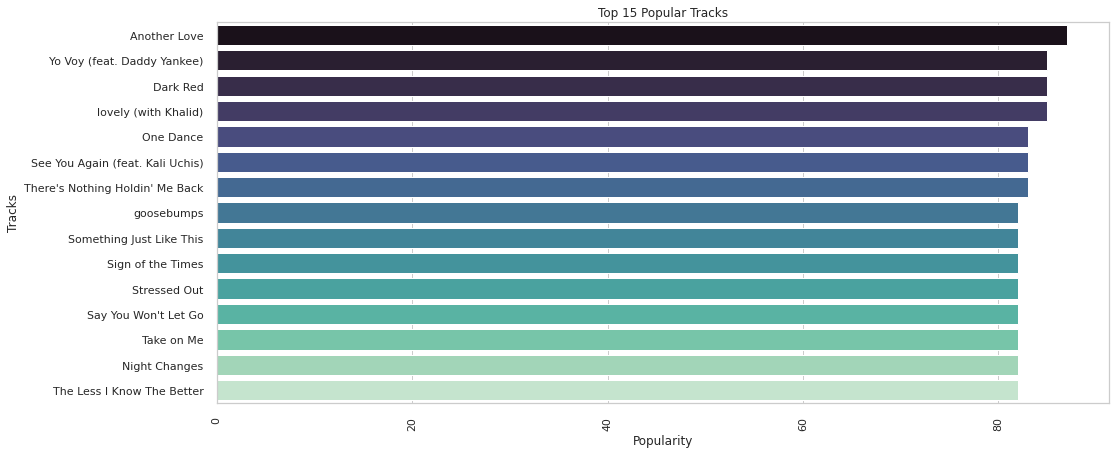

In [26]:
#Most Popular Tracks
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd.groupby("track_name")['track_popularity'].mean().sort_values(ascending=False).head(15)
axis = sns.barplot(popular,popular.index,palette="mako",orient = 'h')
axis.set_title('Top 15 Popular Tracks')
axis.set_ylabel('Tracks')
axis.set_xlabel('Popularity')
plt.xticks(rotation = 90)

## Most Popular Artists

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 <a list of 6 Text major ticklabel objects>)

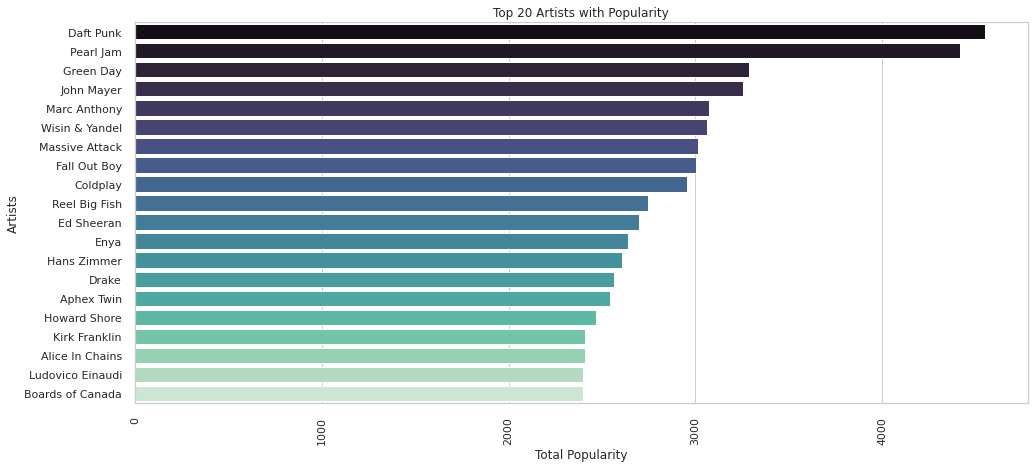

In [27]:
#Most Popular Artists
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd.groupby("artist_name")['track_popularity'].sum().sort_values(ascending=False)[:20]
axis = sns.barplot(popular,popular.index,palette="mako",orient = 'h')
axis.set_title('Top 20 Artists with Popularity')
axis.set_ylabel('Artists')
axis.set_xlabel('Total Popularity')
plt.xticks(rotation = 90)

## Most present Artist

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 9 Text major ticklabel objects>)

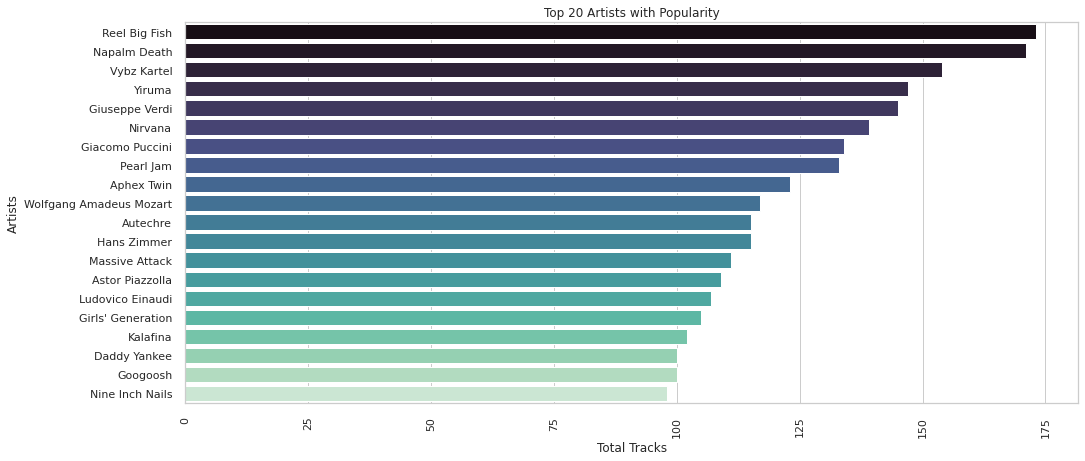

In [28]:
#Most Popular Artists
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd["artist_name"].value_counts()[:20]
#popular.columns = ['feature','nunique']
#axis = sns.barplot(x='feature', y='nunique', data=popular, palette="mako")
axis = sns.barplot(popular, popular.index, palette="mako",orient = 'h')
axis.set_title('Top 20 Artists with Popularity')
axis.set_ylabel('Artists')
axis.set_xlabel('Total Tracks')
plt.xticks(rotation = 90)

## Most popular artist through the years

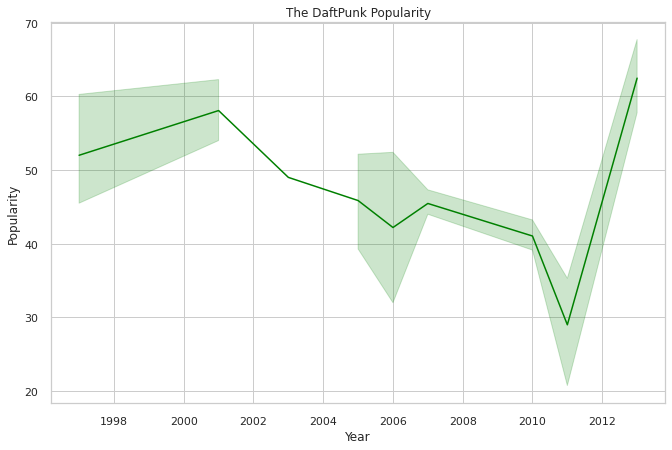

In [29]:
# visualize the popularity of PearlJam songs over the year
DaftPunk = spotify_tracks_pd[spotify_tracks_pd['artist_name'] == 'Daft Punk']
plt.rcParams['figure.figsize'] = (11,7)
# line plot passing x,y
sns.lineplot(x='year', y='track_popularity', data=DaftPunk, color='green')
# Labels
plt.title("The DaftPunk Popularity")
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

## Audio characteristics over the years

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

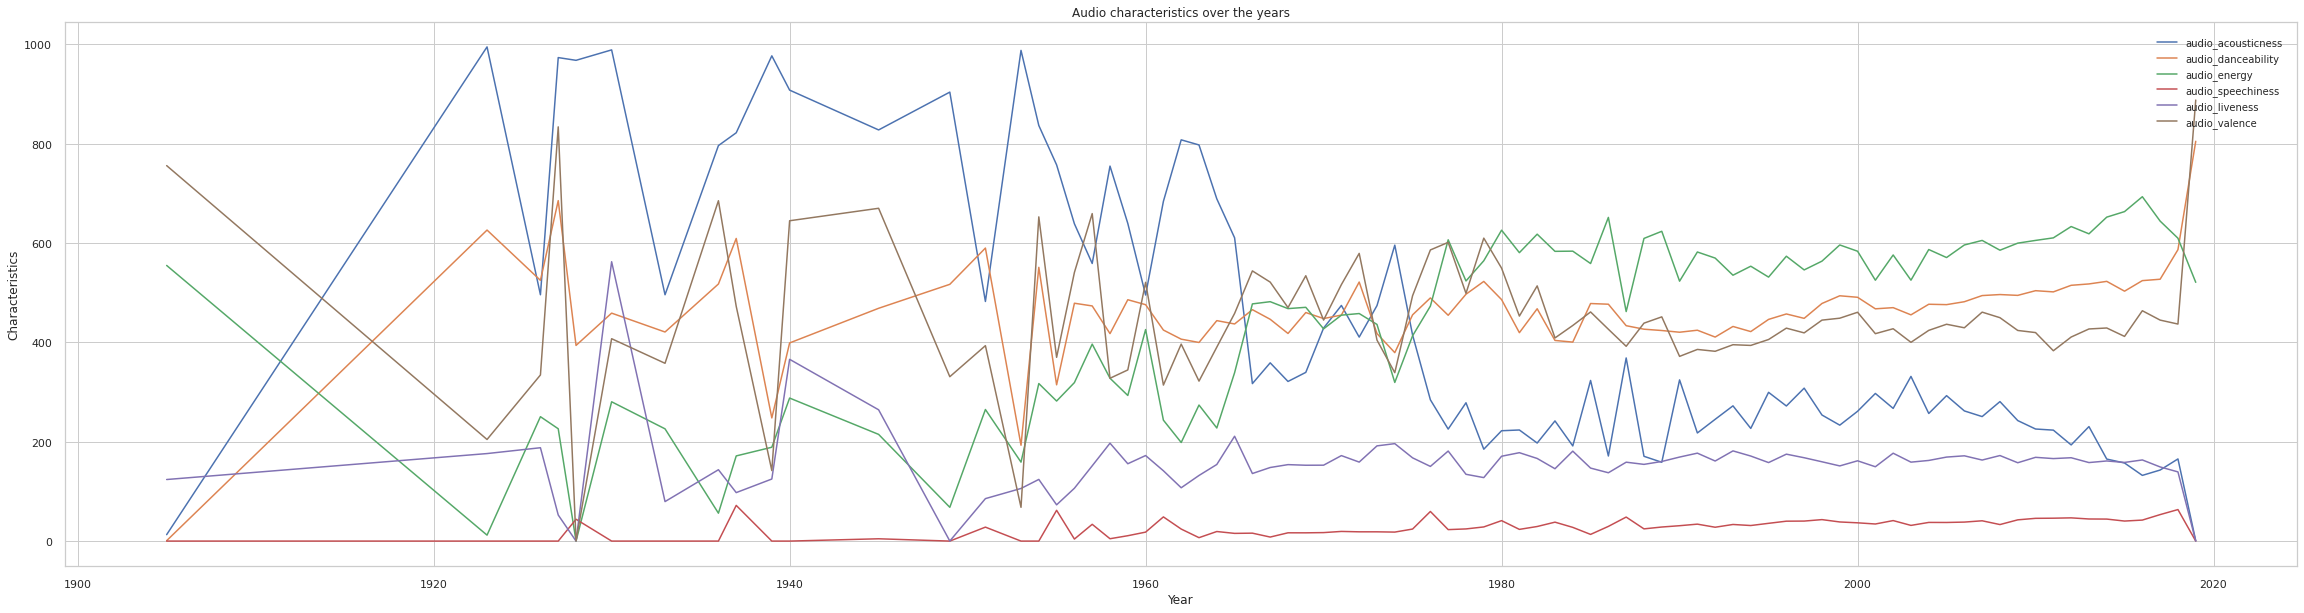

In [30]:

columns = ["audio_acousticness","audio_danceability","audio_energy","audio_speechiness","audio_liveness","audio_valence"]
plt.figure(figsize=(40,10))
for c in columns:
    x = spotify_tracks_pd.groupby('year')[c].mean()
    sns.lineplot(x.index,x,label=c)
plt.title('Audio characteristics over the years')
plt.xlabel('Year')
plt.ylabel('Characteristics')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10}, loc = 'upper right')
plt.show()

## Number of songs released Year Wise

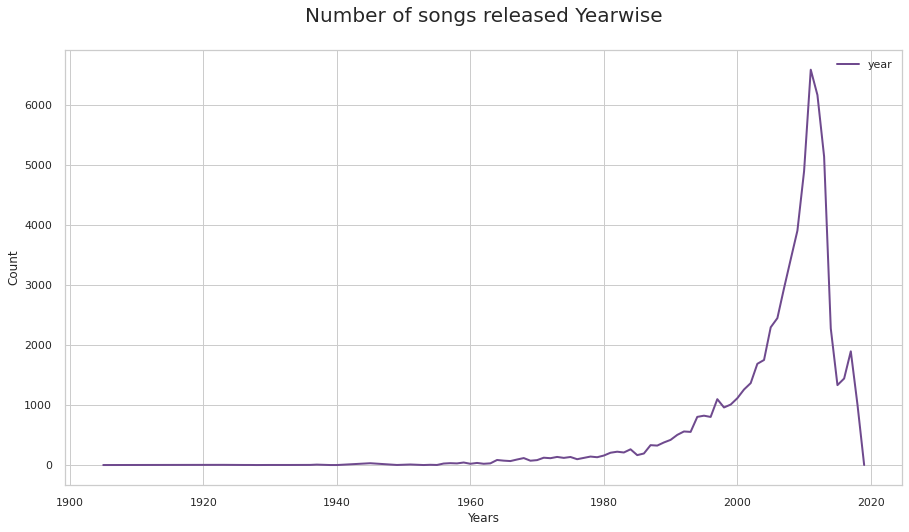

In [31]:
year = pd.DataFrame(spotify_tracks_pd['year'].value_counts())
year = year.sort_index()
ax=year.plot(kind='line',figsize=(15,8) ,color='#6f4a8e', linewidth=2)
plt.title("Number of songs released Yearwise",y=1.05,fontsize=20)
plt.xlabel('Years')
plt.ylabel('Count')
ax.axes.get_xaxis().set_visible(True)

## Danceability VS Popularity

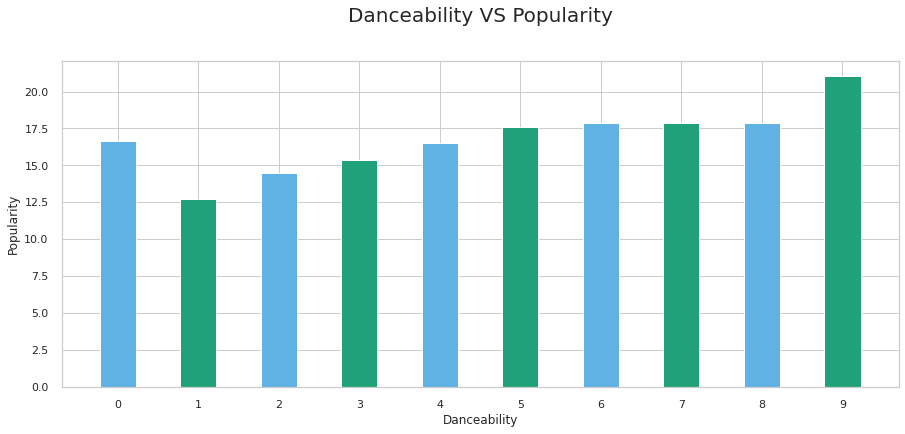

In [32]:
# Da rivedere

bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] #, np.inf]
names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

spotify_tracks_pd['audio_danceability_map'] = pd.cut(spotify_tracks_pd['audio_danceability'], bins, labels=names)

keypop = pd.DataFrame(spotify_tracks_pd.groupby('audio_danceability_map')['track_popularity'].mean()).reset_index()

fig = plt.figure(figsize=(15,6))
plt.bar( keypop['audio_danceability_map'],
         keypop['track_popularity'],
         width=0.45,
         color = ['#60B2E5','#21A179'])
plt.title('Danceability VS Popularity',y=1.1,fontsize=20)
plt.xlabel('Danceability')
plt.ylabel('Popularity')
ax.axes.get_xaxis().set_visible(True)

We can see that as danceability increases, so does popularity except for the 0 value, perhaps because Spotify sets it as the default if it doesn't have enough information.

## Da Fare Year VS Popularity

## Key VS Popularity

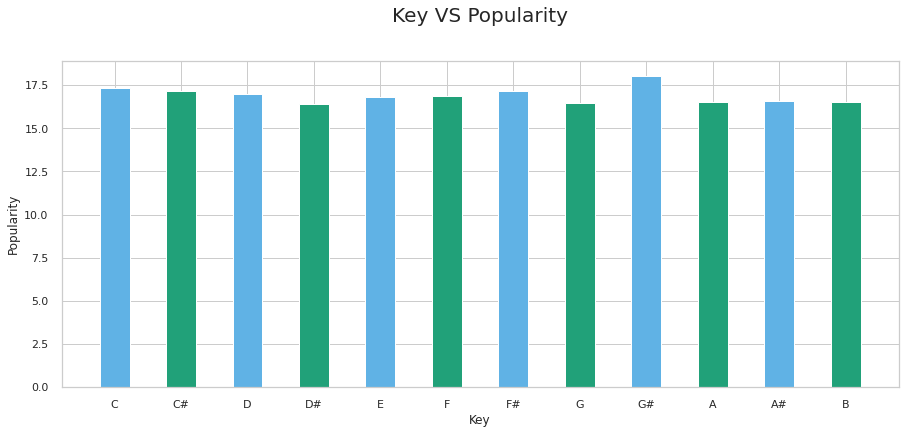

In [33]:
keypop = pd.DataFrame(spotify_tracks_pd.groupby('audio_key_1')['track_popularity'].mean()).reset_index()
keypop.replace({'audio_key_1' : { 0 : 'C', 1 : 'C#', 2 : 'D', 3 : 'D#', 4 : 'E', 5 : 'F', 6 : 'F#', 
                        7 : 'G', 8 : 'G#', 9 : 'A', 10 : 'A#', 11 : 'B'}} , inplace=True)

fig = plt.figure(figsize=(15,6))
plt.bar( keypop['audio_key_1'],
         keypop['track_popularity'],
         width=0.45,
         color = ['#60B2E5','#21A179'])
plt.title('Key VS Popularity',y=1.1,fontsize=20)
plt.xlabel('Key')
plt.ylabel('Popularity')
ax.axes.get_xaxis().set_visible(True)

## Key VS Genre

In [38]:
def invert_dict(): 
    # Reverse json 

    import json

    # Opening JSON file
    # f = open('https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/map_genre_small.json')
    f = open('map_genre_small.json')
    d = json.load(f)
    f.close()

    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = key 
            #else: 
            #    inverse[item].append(key) 
    return inverse

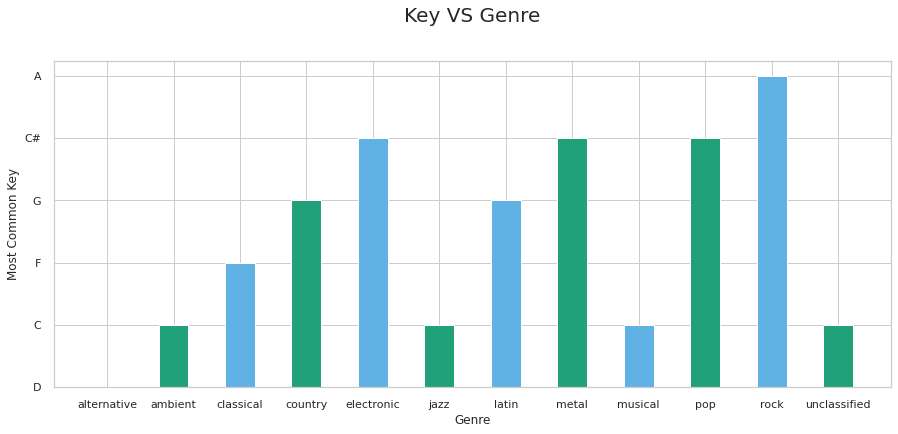

In [39]:
map_genre_inv = invert_dict()

key_genre = pd.DataFrame(spotify_tracks_pd)
key_genre["track_genre"].replace(map_genre_inv, inplace=True)
key_genre.replace({'audio_key_1' : { 0 : 'C', 1 : 'C#', 2 : 'D', 3 : 'D#', 4 : 'E', 5 : 'F', 6 : 'F#', 
                        7 : 'G', 8 : 'G#', 9 : 'A', 10 : 'A#', 11 : 'B'}} , inplace=True)

key_genre = key_genre.groupby(['track_genre'])['audio_key_1'].agg(pd.Series.mode)

key_genre = pd.DataFrame({"track_genre":key_genre.index, "audio_key_1":key_genre.values})

fig = plt.figure(figsize=(15,6))
plt.bar( key_genre["track_genre"],
         key_genre["audio_key_1"],
         width=0.45,
         color = ['#60B2E5','#21A179'])
plt.title('Key VS Genre',y=1.1,fontsize=20)
plt.xlabel('Genre')
plt.ylabel('Most Common Key')
ax.axes.get_xaxis().set_visible(True)


# Discretize

## Discretize the Genres

In [40]:
if map_genre_inv == {}:
  map_genre_inv = invert_dict()

In [41]:
# Map the 126 genres to 12 Big-Genres from the dict file
udf_foo = udf(lambda x: map_genre_inv[x], StringType())
spotify_tracks = spotify_tracks.withColumn("track_genre", udf_foo("track_genre"))

In [42]:
spotify_tracks.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,unclassified,rock,classical,latin
count,5995,6000,2722,13579,2896,5315,3189,3600,8950,5283,2393,5028


In [43]:
spotify_tracks = spotify_tracks.filter(spotify_tracks.track_genre != 'unclassified')
spotify_tracks.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,rock,classical,latin
count,5995,6000,2722,13579,2896,5315,3189,3600,5283,2393,5028


We drop the "unclassified" rows because contains all Spotify genres that are not properly real genres, for example we esclude Nation genre (like british, french ecc).

## Discretize the Popularity

In this task our target class is the popularity of the track, i.e. the "track_popularity" feature in our dataset. We want to discretize this class in 10 classes (0-9). A popularity equals to 0 means that the track is unknows, instead it means that the track is known by everyone.

In [44]:
splits = [i for i in range(0,101)]
splits = splits[::10]
splits

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [45]:
buck = Bucketizer(splits=splits,inputCol="track_popularity",outputCol="track_popularity_bucket")
spotify_tracks = buck.transform(spotify_tracks)

# Delete track_popularity column
spotify_tracks = spotify_tracks.drop("track_popularity")

spotify_tracks.groupBy('track_popularity_bucket').count().show()

+-----------------------+-----+
|track_popularity_bucket|count|
+-----------------------+-----+
|                    8.0|   81|
|                    0.0|31380|
|                    7.0|  849|
|                    1.0| 4925|
|                    4.0| 3835|
|                    3.0| 4833|
|                    2.0| 4978|
|                    6.0| 2116|
|                    5.0| 3003|
+-----------------------+-----+



In [46]:
# now we want named for each bucket
# if 1 < popularity <= 3: low
# if 3 < popularity <= 5: medium
# if 5 < popularity <= 9: high

# to perform this operation we use udf that allows to create a new column with 
# bucket names 

t = {0.0:"unknow", 1.0:"low", 2.0:"low", 3.0:"medium", 4.0:"medium", 5.0:"medium", 
     6.0:"high", 7.0:"high", 8.0:"high", 9.0:"high"}
udf_foo = udf(lambda x: t[x], StringType())
spotify_tracks = spotify_tracks.withColumn("track_popularity_bucket", udf_foo("track_popularity_bucket"))

In [47]:
spotify_tracks.groupBy('track_popularity_bucket').count().toPandas().transpose()

,0,1,2,3
track_popularity_bucket,low,high,medium,unknow
count,9903,3046,11671,31380


In [48]:
spotify_tracks.cache()

DataFrame[track_name: string, track_explicit: boolean, album_name: string, album_release_date_precision: string, artist_name: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_genre: string, pitch_1: double, pitch_2: double, pitch_3: double, pitch_4: double, pitch_5: double, pitch_6: double, pitch_7: double, pitch_8: double, pitch_9: double, pitch_10: double, pitch_11: double, pitch_12: double, timbre_1: double, timbre_2: double, timbre_3: double, timbre_4: double, timbre_5: double, timbre_6: double, timbre_7: double, timbre_8: double, timbre_9: double, timbre_10: double, timbre_11: double, timbre_12: double, day: int, month: int, year: int, track_popularity_bucket: string]

# Sample and Create two Dataset, one for Genre and one for Popularity

## Genre Prevision Dataset

We apply random sample to undersampling the dataset

In [49]:
# Balance and create dataset for genre prevision
fractions_dict = spotify_tracks.groupBy('track_genre').count().toPandas().to_dict()

fraction = {}
for genre in fractions_dict["track_genre"]:
  g = fractions_dict["track_genre"][genre]
  # fraction[g] = 2000 / fractions_dict["count"][genre] 
  fraction[g] = 1200 / fractions_dict["count"][genre] 

del fractions_dict



spotify_tracks_genre = spotify_tracks.sampleBy("track_genre", fractions=fraction, seed=0)
spotify_tracks_genre.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,rock,classical,latin
count,1241,1200,1193,1227,1228,1179,1212,1216,1214,1181,1198


## Popularity Prevision Dataset

We apply random sample to undersampling the dataset


In [50]:
fractions_dict = spotify_tracks.groupBy('track_popularity_bucket').count().toPandas().to_dict()

fraction = {}
for popularity in fractions_dict["track_popularity_bucket"]:
  g = fractions_dict["track_popularity_bucket"][popularity]
  fraction[g] = 3000 / fractions_dict["count"][popularity] 

del fractions_dict



spotify_tracks_popularity = spotify_tracks.sampleBy("track_popularity_bucket", fractions=fraction, seed=0)
spotify_tracks_popularity.groupBy('track_popularity_bucket').count().toPandas().transpose()

,0,1,2,3
track_popularity_bucket,low,high,medium,unknow
count,2970,3012,3067,3138


# **Preprocessing**

In [51]:
# Let's define some constants which we will use throughout this notebook
NUMERICAL_FEATURES_POPULARITY = []
CATEGORICAL_FEATURES_POPULARITY = []
TARGET_VARIABLE_POPULARITY = "track_popularity_bucket"

#Get All column names and it's types
for col in spotify_tracks_popularity.dtypes:
    if col[1] == "string":
        CATEGORICAL_FEATURES_POPULARITY.append(col[0])
    else:
        NUMERICAL_FEATURES_POPULARITY.append(col[0])

CATEGORICAL_FEATURES_POPULARITY.remove(TARGET_VARIABLE_POPULARITY)

print("Categorical Popularity Dataset: ", CATEGORICAL_FEATURES_POPULARITY)
print("Numerical Popularity Dataset: ", NUMERICAL_FEATURES_POPULARITY)

Categorical Popularity Dataset:  ['track_name', 'album_name', 'album_release_date_precision', 'artist_name', 'track_genre']
Numerical Popularity Dataset:  ['track_explicit', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'audio_time_signature', 'audio_valence', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11', 'pitch_12', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'timbre_12', 'day', 'month', 'year']


In [52]:
# Let's define some constants which we will use throughout this notebook
NUMERICAL_FEATURES_GENRE = []
CATEGORICAL_FEATURES_GENRE = []
TARGET_VARIABLE_GENRE = "track_genre"

#Get All column names and it's types
for col in spotify_tracks_genre.dtypes:
    if col[1] == "string":
        CATEGORICAL_FEATURES_GENRE.append(col[0])
    else:
        NUMERICAL_FEATURES_GENRE.append(col[0])

CATEGORICAL_FEATURES_GENRE.remove(TARGET_VARIABLE_GENRE)

print("Categorical Genre Dataset: ", CATEGORICAL_FEATURES_GENRE)
print("Numerical Genre Dataset: ", NUMERICAL_FEATURES_GENRE)

Categorical Genre Dataset:  ['track_name', 'album_name', 'album_release_date_precision', 'artist_name', 'track_popularity_bucket']
Numerical Genre Dataset:  ['track_explicit', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'audio_time_signature', 'audio_valence', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11', 'pitch_12', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'timbre_12', 'day', 'month', 'year']


## Feature Selection

In [63]:
"""
# FEATURE SELECTION FOR GENRE

# Da fare !!!!! Guardare esempio git hub

feature_names = NUMERICAL_FEATURES_GENRE
stg = spotify_tracks_genre.toPandas()
y = stg['track_genre']
X = stg.drop('track_genre', axis=1)


# Create a list of the feature names
features = np.array(feature_names)
# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(30,30)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()  
"""

TypeError: ignored

In [ ]:
"""
# FEATURE SELECTION FOR POPULARITY

# Da fare !!!!! Guardare esempio git hub

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_min','explicit','key','mode','year']

X, y = df[feature_names], df['popularity']

# Create a list of the feature names

features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(30,30)
visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()  
"""

## Transform Categorical features into Numerical using One-Hot Encoding

Note that this step is not always mandatory (e.g., decision trees are able to work nicely with categorical features without the need of transforming them to numerical). Still, other methods (like logistic regression) are designed to operate with numerical inputs only.

To transform _categorical_ features into _numerical_ ones we proceed as follows.
We setup a pipeline which is composed of the following steps:
- [`StringIndexer`](https://spark.apache.org/docs/latest/ml-features#stringindexer): encodes a string column of labels to a column of label indices. The indices are in `[0, numLabels)`, and 4 ordering options are supported (default `frequencyDesc`, which assigns the most frequent label the index `0`, and so on and so forth).
- [`OneHotEncoderEstimator`](https://spark.apache.org/docs/latest/ml-features#onehotencoderestimator): maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. An important parameter is `handleInvalid`, which indicates how to deal with previously unseen labels. By default this raises an error but it can be set to as `keep` to assign previously unseen labels a fallback value.
- [`VectorAssembler`](https://spark.apache.org/docs/latest/ml-features#vectorassembler): is a transformer that combines a given list of columns into a single vector column.

In [ ]:
# This function is responsible to implement the pipeline above for transforming categorical features into numerical ones
def to_numerical(df, numerical_features, categorical_features, target_variable):
  
    # 1. Label Encode target feature
    # In this case our target is the popularity of the tracks that is just
    # numeric in our dataframe, so there is no need to encode it 
    stage_1= StringIndexer(inputCol=target_variable, outputCol='label')

    # 2. Label Encode Categorical features
    stage_2 = [StringIndexer(inputCol=c, outputCol="{0}_index".format(c), handleInvalid="skip") for c in categorical_features]

    # 3. OneHot Encode 
    # stage_3 = OneHotEncoder(inputCol='album_release_date_precision_index', outputCol='album_release_date_precision_oh')

    # 4. create a vector of all the features required to train the logistic regression model 
    # encoded_columns = ['track_name_index', 'album_name_index', 'artist_name_index', 'album_release_date_precision_oh']
    # stage_4 = VectorAssembler(inputCols= encoded_columns + numerical_features, outputCol='features')
    stage_4 = VectorAssembler(inputCols= [indexer.getOutputCol() for indexer in stage_2] + numerical_features, outputCol='features')

    # 4.a Create the StandardScaler
    scaler = StandardScaler(inputCol=stage_4.getOutputCol(), outputCol="std_" + stage_4.getOutputCol(), withStd=True, withMean=True)

    # 5. Populate the stages of the pipeline
    stages = [stage_1] + stage_2 + [stage_4] + [scaler]

    # 6. Setup the pipeline with the stages above
    pipeline = Pipeline(stages=stages)

    # 7. Transform the input dataframe accordingly
    transformer = pipeline.fit(df)
    df_transformed = transformer.transform(df)

    return df_transformed

In [ ]:
spotify_tracks.cache()

DataFrame[track_name: string, track_explicit: boolean, track_popularity: int, album_name: string, album_release_date_precision: string, artist_name: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_genre: string, pitch_1: double, pitch_2: double, pitch_3: double, pitch_4: double, pitch_5: double, pitch_6: double, pitch_7: double, pitch_8: double, pitch_9: double, pitch_10: double, pitch_11: double, pitch_12: double, timbre_1: double, timbre_2: double, timbre_3: double, timbre_4: double, timbre_5: double, timbre_6: double, timbre_7: double, timbre_8: double, timbre_9: double, timbre_10: double, timbre_11: double, timbre_12: double, day: int, month: int, year: int]

# **Split the Dataset into train and test set**
## **Dataset Splitting: Training vs. Test Set**

Before moving along with any preprocessing involving data transformations, we will split our dataset into **2** portions:
- _training set_ (e.g., accounting for **80%** of the total number of instances);
- _test set_ (e.g., accounting for the remaining **20%** of instances)

In [ ]:
# GENRE DATASET

# Transform the training set and get back both the transformer and the new dataset
spotify_tracks_genre = to_numerical(spotify_tracks_genre, NUMERICAL_FEATURES_GENRE, CATEGORICAL_FEATURES_GENRE, TARGET_VARIABLE_GENRE)
spotify_tracks_genre.cache()

# Select `features` and `label` (i.e., formerly `deposit`) target variable only
spotify_tracks_genre = spotify_tracks_genre.select(["std_features", "label"])
spotify_tracks_genre.cache()

RANDOM_SEED = 42
# Randomly split our original dataset `house_df` into 80÷20 for training and test, respectively
train_set_genre, test_set_genre = spotify_tracks_genre.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

train_set_genre.show()

+--------------------+-----+
|        std_features|label|
+--------------------+-----+
|[-1.5432572913072...|  8.0|
|[-1.5304963122137...|  4.0|
|[-1.5281036286336...|  2.0|
|[-1.5231587492349...|  1.0|
|[-1.4638201964498...|  6.0|
|[-1.4571206824257...|  0.0|
|[-1.4504211684015...|  0.0|
|[-1.4256967714078...|  6.0|
|[-1.4068743272447...|  4.0|
|[-1.4027270090393...|  2.0|
|[-1.3757694407042...|  2.0|
|[-1.3596587045985...|  2.0|
|[-1.3392411380488...| 10.0|
|[-1.3162713756804...| 10.0|
|[-1.2944181989827...| 10.0|
|[-1.2097172002491...|  1.0|
|[-1.1977537823489...|  7.0|
|[-1.1105005877967...|  2.0|
|[-1.0604137448544...|  1.0|
|[-0.8914902841033...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# POPULARITY DATASET

# Transform the training set and get back both the transformer and the new dataset
spotify_tracks_popularity = to_numerical(spotify_tracks_popularity, NUMERICAL_FEATURES_POPULARITY, CATEGORICAL_FEATURES_POPULARITY, TARGET_VARIABLE_POPULARITY)
spotify_tracks_popularity.cache()

# Select `features` and `label` (i.e., formerly `deposit`) target variable only
spotify_tracks_popularity = spotify_tracks_popularity.select(["std_features", "label"])
spotify_tracks_popularity.cache()

RANDOM_SEED = 42
# Randomly split our original dataset `house_df` into 80÷20 for training and test, respectively
train_set_popularity, test_set_popularity = spotify_tracks_popularity.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

train_set_popularity.show()

+--------------------+-----+
|        std_features|label|
+--------------------+-----+
|[-1.5702805019363...|  0.0|
|[-1.5619422607606...|  1.0|
|[-1.5268641427108...|  2.0|
|[-1.5127753903793...|  2.0|
|[-1.5087500325703...|  0.0|
|[-1.4072535106722...|  0.0|
|[-1.2111610802629...|  1.0|
|[-1.1599815309772...|  3.0|
|[-1.1594064798616...|  3.0|
|[-0.9745275462059...|  0.0|
|[-0.9075340912420...|  3.0|
|[-0.8692931920566...|  1.0|
|[-0.7948240725903...|  1.0|
|[-0.6358224391352...|  1.0|
|[-0.6016068977588...|  3.0|
|[-0.4670449367154...|  1.0|
|[-0.4480682499016...|  2.0|
|[-0.3641107870284...|  1.0|
|[-0.3204069022451...|  1.0|
|[-0.2097095624979...|  2.0|
+--------------------+-----+
only showing top 20 rows



# Training

## Decision Tree

In [ ]:
# This function defines the general pipeline for logistic regression
def decision_tree_pipeline(train):
  
  stage_5_dr = DecisionTreeClassifier(featuresCol='std_features',labelCol='label')

  decision_tree_pipeline = Pipeline(stages= [stage_5_dr])

  #### DECISION TREE
  param_grid = ParamGridBuilder()\
    .addGrid(stage_5_dr.maxDepth, [3, 5, 8]) \
    .addGrid(stage_5_dr.impurity, ["gini", "entropy"]) \
    .build()
  cross_val_dt = CrossValidator(estimator=decision_tree_pipeline,
                                estimatorParamMaps=param_grid,
                                evaluator=MulticlassClassificationEvaluator(),
                                numFolds=5,
                                collectSubModels=True
                                )
  cv_model_dt = cross_val_dt.fit(train)

  return cv_model_dt

In [ ]:
cv_model_genre_dt = decision_tree_pipeline(train_set_genre)

test_predictions_genre_dt = cv_model_genre_dt.transform(test_set_genre)

test_predictions_genre_dt.select("std_features", "prediction", "label").show(5)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 46818)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 480, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 504, in send_command
    "Error while sending or receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while sending or receiving
Traceback (most recent call last):
  File "/usr/lib/python3.7/socketserver.py", line 316, in _handle_request

Py4JError: ignored

In [ ]:
cv_model_popularity_dt = decision_tree_pipeline(train_set_popularity)

test_predictions_popularity_dt = cv_model_popularity_dt.transform(test_set_popularity)

test_predictions_popularity_dt.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.5702805019363...|       0.0|  0.0|
|[-1.5619422607606...|       1.0|  1.0|
|[-1.5268641427108...|       2.0|  2.0|
|[-1.5127753903793...|       2.0|  2.0|
|[-1.5087500325703...|       2.0|  0.0|
+--------------------+----------+-----+
only showing top 5 rows



## **Logistic Regression**

We first train a logistic regression model, using the training set above. To do so, we use the `LogisticRegression` object provided by the [PySpark API](https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression) within the package `pyspark.ml.classification`.

The API is similar to the one we have seen for Linear Regression (i.e., implementing the **Elastic Net** regularization framework), except for the loss function which now is **cross-entropy** rather than **mean squared error**:
$$
\boldsymbol{\theta}^* = \text{argmin}_{\boldsymbol{\theta}\in \mathbb{R}^n} \frac{1}{m} \sum_{i=1}^m \log_e(1 + e^{-y_i\boldsymbol{\theta}^T\mathbf{x}_i}) + \lambda\Big(\alpha |\boldsymbol{\theta}| + (1-\alpha)||\boldsymbol{\theta}||^2\Big)
$$
In particular, we can specify the following parameters:

- `regParam` is the regularization parameter (or $\lambda$);
- `elasticNetParam` is the tradeoff parameter for regularization penalties (or $\alpha$);
  - `regParam = 0` and `elasticNetParam = 0` means there is no regularization;
  - `regParam > 0` and `elasticNetParam = 0` means there is only L2-regularization; 
  - `regParam > 0` and `elasticNetParam = 1` means there is only L1-regularization;
  - `regParam > 0` and `0 < elasticNetParam < 1` means there is both L1- and L2-regularization (Elastic Net);

As it is always the case, the optimal values of those **hyperparameters** should be tuned using a dedicated portion of the dataset (i.e., **validation set**) or by performing $k$**-fold cross validation**.

In [ ]:
# This function defines the general pipeline for logistic regression
def logistic_regression_pipeline(train):
  
    stage_5_lg = LogisticRegression(featuresCol='std_features',labelCol='label')

    logistic_regression_pipeline = Pipeline(stages= [stage_5_lg])

    #### LOGISTIC REGRESSION
    param_grid = ParamGridBuilder()\
    .addGrid(stage_5_lg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(stage_5_lg.maxIter, [10, 20, 50]) \
    .build()
    # other param: .addGrid(stage_4_lg.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])
    cross_val_lg = CrossValidator(estimator=logistic_regression_pipeline,
                            estimatorParamMaps=param_grid,
                            evaluator=MulticlassClassificationEvaluator(), 
                            numFolds=5,
                            collectSubModels=True
                            )
    cv_model_lg = cross_val_lg.fit(train)

    return cv_model_lg

In [ ]:
cv_model_genre_lg = logistic_regression_pipeline(train_set_genre)

test_predictions_genre_lg = cv_model_genre_lg.transform(test_set_genre)

test_predictions_genre_lg.select("std_features", "prediction", "label").show(5)

In [ ]:
cv_model_popularity_lg = logistic_regression_pipeline(train_set_popularity)

test_predictions_popularity_lg = cv_model_popularity_lg.transform(test_set_popularity)

test_predictions_popularity_lg.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.5300269238464...|       0.0|  2.0|
|[-1.4664837755759...|       0.0|  2.0|
|[-1.3951774372453...|       3.0|  3.0|
|[-0.9391619025983...|       0.0|  0.0|
|[-0.4676199878310...|       3.0|  2.0|
+--------------------+----------+-----+
only showing top 5 rows



## Random Forest

In [ ]:
# This function defines the general pipeline for logistic regression
def random_forest_pipeline(train):
  
  stage_5_rf = RandomForestClassifier(featuresCol="std_features", labelCol="label")

  random_forest_pipeline = Pipeline(stages= [stage_5_rf])

  #### RANDOM FOREST
  param_grid = ParamGridBuilder()\
    .addGrid(stage_5_rf.maxDepth, [3, 5, 8]) \
    .addGrid(stage_5_rf.numTrees, [10, 50, 100]) \
    .build()

  cross_val_rf = CrossValidator(estimator=random_forest_pipeline, 
                              estimatorParamMaps=param_grid,
                              evaluator= MulticlassClassificationEvaluator(),
                              numFolds=5,
                              collectSubModels=True 
                              )
  cv_model_rf = cross_val_rf.fit(train)

  return cv_model_rf

In [ ]:
cv_model_genre_rf = random_forest_pipeline(train_set_genre)

test_predictions_genre_rf = cv_model_genre_rf.transform(test_set_genre)

test_predictions_genre_rf.select("std_features", "prediction", "label").show(5)

In [ ]:
cv_model_popularity_rf = random_forest_pipeline(train_set_popularity)

test_predictions_popularity_rf = cv_model_popularity_rf.transform(test_set_popularity)

test_predictions_popularity_rf.select("std_features", "prediction", "label").show(5)

## Multi Layer Perceptron

In [ ]:
# This function defines the general pipeline for logistic regression
def multi_layer_perceptron_pipeline(train):
  
  stage_5_mlp = MultilayerPerceptronClassifier(featuresCol="std_features", labelCol="label")

  multi_layer_perceptron_pipeline = Pipeline(stages= [stage_5_rf])

  #### MULTI LAYER PERCEPTRON
  param_grid = ParamGridBuilder()\
    .addGrid(stage_5_rf.layers, [[4,5,3], [4,5,5,3], [4,10,7,5]]) \
    .addGrid(stage_5_rf.seed, [0, 123]) \
    .build()

  cross_val_mlp = CrossValidator(estimator=multi_layer_perceptron_pipeline, 
                              estimatorParamMaps=param_grid,
                              evaluator= MulticlassClassificationEvaluator(),
                              numFolds=5,
                              collectSubModels=True 
                              )
  cv_model_mlp = cross_val_mlp.fit(train)

  return cv_model_mlp

In [ ]:
cv_model_genre_mlp = multi_layer_perceptron_pipeline(train_set_genre)

test_predictions_genre_mlp = cv_model_genre_mlp.transform(test_set_genre)

test_predictions_genre_mlp.select("std_features", "prediction", "label").show(5)

In [ ]:
cv_model_popularity_mlp = multi_layer_perceptron_pipeline(train_set_popularity)

test_predictions_popularity_mlp = cv_model_popularity_mlp.transform(test_set_popularity)

test_predictions_popularity_mlp.select("std_features", "prediction", "label").show(5)

# Evaluation


In [ ]:
def evaluate(cv_model, test_prediction):

  for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
      print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

  print(cv_model.bestModel.stages[-1])

  print("##### Test Set #####")
  evaluator = cv_model.getEvaluator()
  print('Test F1-Score ',   evaluator.evaluate(test_prediction, {evaluator.metricName: 'f1'}))
  print('Test Precision ',  evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedPrecision'}))
  print('Test Recall ',     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedRecall'}))
  print('Test Accuracy ',   evaluator.evaluate(test_prediction, {evaluator.metricName: 'accuracy'}))
  print("####################")

  # Questa poi la useremo per fare i plot di confronto tra i vari modelli
  evaluation_list = [evaluator.evaluate(test_prediction, {evaluator.metricName: 'f1'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedPrecision'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedRecall'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'accuracy'})]

  return evaluation_list

## Decision Tree

In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model_genre_dt.bestModel.stages[-1]._java_obj.getMaxDepth()
             )
      )
el_genre_dt = evaluate(cv_model_genre_dt, test_predictions_genre_dt)

In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model_popularity_dt.bestModel.stages[-1]._java_obj.getMaxDepth()
             )
      )
el_popularity_dt = evaluate(cv_model_popularity_dt, test_predictions_popularity_dt)

## Logistic Regression

In [ ]:
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(cv_model_genre_lg.bestModel.stages[-1]._java_obj.getRegParam(),
             cv_model_genre_lg.bestModel.stages[-1]._java_obj.getElasticNetParam()
             )
      )

el_genre_lg = evaluate(cv_model_genre_lg, test_predictions_genre_lg)

In [ ]:
print("Best model according to k-fold cross validation: lambda=[{:.3f}]; alfa=[{:.3f}]".
      format(cv_model_popularity_lg.bestModel.stages[-1]._java_obj.getRegParam(),
             cv_model_popularity_lg.bestModel.stages[-1]._java_obj.getElasticNetParam()
             )
      )

el_popularity_lg = evaluate(cv_model_popularity_lg, test_predictions_popularity_lg)

## Random Forest

In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model_genre_rf.bestModel.stages[-1]._java_obj.getMaxDepth()
             )
      )
el_genre_rf = evaluate(cv_model_genre_rf, test_predictions_genre_rf)

In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model_popularity_rf.bestModel.stages[-1]._java_obj.getMaxDepth()
             )
      )
el_popularity_rf = evaluate(cv_model_popularity_rf, test_predictions_popularity_rf)

## Multi Layer Perceptron

In [ ]:
print("Best model according to k-fold cross validation: ", cv_model_genre_mlp.bestModel.stages[-1]._java_obj.getLayers())
el_genre_mlp = evaluate(cv_model_genre_mlp, test_predictions_genre_mlp)

In [ ]:
print("Best model according to k-fold cross validation: ", cv_model_popularity_mlp.bestModel.stages[-1]._java_obj.getLayers())
el_popularity_mlp = evaluate(cv_model_popularity_mlp, test_predictions_popularity_mlp)

## Model Comparison

In [ ]:
def plot(total_list)
  # List of required attributes
  attributes = ["Decision Tree", "Logistic Regression", "Random Forest", "Multi Layer Perceptron"]

  # Arrays used to store the total number of Boolean values for each feature
  total_f1 = total_list[0, 4, 8, 12]
  total_wP = total_list[1, 5, 9, 13]
  total_wR = total_list[2, 6, 10, 14]
  total_ac = total_list[3, 7, 11, 15]

  # Declaring the figure or the plot (y, x) or (width, height)
  plt.figure(figsize=[20, 10])

  # Using numpy to group different data with bars
  number_list = np.arange(len(total_zero))

  for attribute in attributes:
      plt.bar(number_list, total_f1, color = 'orange', width = 0.35)
      plt.bar(number_list + 0.35, total_wP, color = 'blue', width = 0.35)
      plt.bar(number_list, total_wR, color = 'red', width = 0.35)
      plt.bar(number_list + 0.35, total_ac, color = 'green', width = 0.35)
      
  # Creating the legend of the bars in the plot
  plt.legend(['f1', 'weightedPrecision', 'weightedRecall', 'accuracy'])

  # Overiding the x axis with the feature names
  plt.xticks([i + 0.35 for i in range(len(attributes))], attributes)

  # Giving the tilte for the plot
  plt.title("Model Comparison")

  # Namimg the x and y axis
  plt.xlabel('Model')
  plt.ylabel('Tot')

  # Displaying the bar plot
  plt.show()

In [ ]:
total_genre_list = el_genre_dt + el_genre_lg + el_genre_dt + el_genre_mlp
plot(total_genre_list)

total_popularity_list = el_popularity_dt + el_popularity_lg + el_popularity_rf + el_popularity_mlp
plot(total_popularity_list)

# Content-based Recommender

In [ ]:
# Testo da "riscirvere"

A content-based recommender leverages attributes from items the user has interacted with to recommend similar items. As it depends only on the past this method avoids the cold-start problem for implementation.

For text items we can use a popular information retrieval method used in search engines named TF-IDF. This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. We can then compute the cosine similarity between the user vector and the initial sparse matrix (all users).

## TF-IDF
First we need to apply the TF-IDF technique, and use it to build playlist profiles

In [ ]:
def get_tfidf(tracks, ngram_range=(1,2), min_df=0.003, max_df=0.5, max_features=5000):
    # Transform list cols to string, we use bigrams later so no need to remove spaces
    tracks['genres_str'] = tracks['genres'].apply(lambda x: ' '.join(x))

    hashingTF = HashingTF()
    tf = hashingTF.transform(tracks)

    # While applying HashingTF only needs a single pass to the data, applying IDF needs two passes:
    # First to compute the IDF vector and second to scale the term frequencies by IDF.
    tf.cache()
    idf = IDF().fit(tf)
    tfidf = idf.transform(tf)

    # spark.mllib's IDF implementation provides an option for ignoring terms
    # which occur in less than a minimum number of documents.
    # In such cases, the IDF for these terms is set to 0.
    # This feature can be used by passing the minDocFreq value to the IDF constructor.
    idfIgnore = IDF(minDocFreq=2).fit(tf)
    tfidfIgnore = idfIgnore.transform(tf)

    return tfidf

    """
    # Vector size 5000 model
    vectorizer = TfidfVectorizer(analyzer='word',
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 max_df=max_df,
                                 max_features=max_features,
                                 stop_words=stopwords.words('english'))  # might need to download stopwords, follow prompt

    # Don't include album_genres column here as similar to genres column and we don't want additional genre weighting in this case 
    # vectorizer.fit_transform takes a string
    tfidf_matrix = vectorizer.fit_transform(tracks['name'] + ' ' +
                                            tracks['artist_name'] + ' ' +
                                            tracks['album_name'] + ' ' +
                                            tracks['playlist_name'] + ' ' +
                                            tracks['genres_str']
                                           )
    tfidf_feature_names = vectorizer.get_feature_names()

    return tfidf_matrix, tfidf_feature_names
    """

In [ ]:
PLAYLIST_DATASET_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + PLAYLIST_DATASET_URL.split("/")[-1]ù

def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200: # Test if everything went ok
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)


print("Retrieving dataset from URL: {} ...".format(PLAYLIST_DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Mounted at /content/gdrive


In [ ]:
playlist_tracks_df = spark.read.load(GDRIVE_DATASET_FILE, 
                           format="csv", 
                           sep=";", 
                           inferSchema="true", 
                           header="true")

In [ ]:


tfidf_matrix = get_tfidf(playlist_tracks_df)
tfidf_matrix

In [ ]:
def get_track_profile(tracks, track_id, tfidf_matrix):
    idx = tracks['id'].tolist().index(track_id)
    track_profile = tfidf_matrix[idx:idx+1]
    return track_profile

def get_track_profiles(tracks, track_ids, tfidf_matrix):
    track_profiles_list = [get_track_profile(tracks, x, tfidf_matrix) for x in track_ids]
    track_profiles = vstack(track_profiles_list)
    return track_profiles

def build_playlists_profile(tracks, playlist_id, interactions_indexed_df, tfidf_matrix):
    # There isn't any weighting we want to do in this case, 
    # but a common approach is weighting by interaction strength (liking, commenting, etc.)
    interaction_tracks_df = interactions_indexed_df.loc[playlist_id]  # duplicate interacted tracks, filter to current playlist
    playlist_track_profiles = get_track_profiles(tracks, interaction_tracks_df['id'], tfidf_matrix)
    # Weighted average for event strengths
#     playlist_track_strengths = np.array(interaction_tracks_df['event_strength']).reshape(-1,1)
#     playlist_track_profiles_array = np.sum(playlist_track_profiles.multiply(playlist_track_strengths), axis=0) / np.sum(playlist_track_strengths)
    playlist_track_profiles_array = np.sum(playlist_track_profiles, axis=0)  # Flattens no_tracksx948 matrix to 1x948 array
    playlist_track_profiles_norm = normalize(playlist_track_profiles_array)
    return playlist_track_profiles_norm

def build_playlists_profiles(tracks, tfidf_matrix): 
    playlist_profiles = {}
    for playlist_id in tracks['playlist_id'].unique():
        interacted_tracks, non_interacted_tracks = get_interacted_tracks(tracks, playlist_id, drop_duplicates=False)
        playlist_profiles[playlist_id] = build_playlists_profile(tracks, playlist_id, interacted_tracks.set_index('playlist_id'), tfidf_matrix)
    return playlist_profiles

In [ ]:
playlist_profiles = build_playlists_profiles(playlist_tracks_df, tfidf_matrix)
len(playlist_profiles), len(playlist_tracks_df['playlist_id'].unique())  # all playlists accounted for

In [ ]:
# Get the keywords for my "Chill" playlist
chill_profile = playlist_profiles[playlist_ids['Chill']]
print(chill_profile.shape)  # 95 songs of vector length 948
pd.DataFrame(sorted(zip(tfidf_feature_names, chill_profile.flatten().tolist()), key=lambda x: -x[1])[:10],  # sort by value desc
             columns=['token', 'relevance'])

## Apply Content-based Recommender
Now with our playlist profiles setup, we can apply a content-based recommender.

In [ ]:
class ContentRecommender:
    
    def __init__(self, tracks, tfidf_matrix, playlist_profiles):
        self.tracks = tracks
        self.tfidf_matrix = tfidf_matrix
        self.playlist_profiles = playlist_profiles
        self.model_name = 'Content-based Recommender'

    def _get_similar_tracks(self, playlist_id):
        #Computes the cosine similarity between the playlist profile and all profiles
        cosine_similarities = cosine_similarity(self.playlist_profiles[playlist_id], self.tfidf_matrix)
        similar_indices = cosine_similarities.argsort().flatten()
        #Sort the similar tracks by similarity
        similar_tracks = sorted([(self.tracks['id'].tolist()[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_tracks
        
    def recommend_tracks(self, playlist_id, ignore_ids=[]):
        similar_tracks = self._get_similar_tracks(playlist_id)
        similar_tracks_non_interacted = list(filter(lambda x: x[0] not in ignore_ids, similar_tracks))
        recommendations_df = pd.DataFrame(similar_tracks_non_interacted, columns=['id', 'recStrength']) \
                                .drop_duplicates(subset='id', keep="first").reset_index() \
                                .sort_values('recStrength', ascending=False)

        return recommendations_df
    
content_model = ContentRecommender(playlist_tracks_df, tfidf_matrix, playlist_profiles)

In [ ]:

content_model_recommendations = content_model.recommend_tracks(playlist_ids['Chill'], interacted_tracks['id'].tolist())
# Get track details from original track data
content_model_recommendations_name = pd.merge(content_model_recommendations, playlist_tracks_df.drop_duplicates(subset='id', keep="first"), how='left', on='id')
content_model_recommendations_name[['id', 'name', 'artist_name', 'album_name', 'recStrength']].head()

In [ ]:
content_model_metrics, content_model_details = model_evaluator.evaluate_model(content_model)

print(content_model_metrics)
content_model_details[[x for x in content_model_details.columns if x != 'playlist_id']] \
    .sort_values('recall@5', ascending=False) \
    .head()

From the token relevance and exceptionally high recall it like the genre of a song is a very powerful recommender for me personally. It is likely that the Spotify breakdown of genres e.g. modern pop and chill pop helps a lot with this, alongside the bias of the dataset being playlist based (which tend to be genre/mood based).